In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import copy
from sklearn.metrics import mean_squared_error

import ase.io


# from utils.librascal import RascalSphericalExpansion
from utils.rascaline import RascalineSphericalExpansion
from utils.models.soap import compute_power_spectrum

from utils.models.linear import LinearModel
from utils.models.full_kernel import FullKernelGap
from utils.models.sparse_kernel import SparseKernelGap
from utils.models.sparse_kernel import select_support_points, SparseKernelGap
from utils.pylode import PyLODESphericalExpansion

In [2]:
def rmse2(actual, predicted):
    a=0
    n=len(actual)
    for i in np.arange(n):
        a+=np.power(actual[i]-predicted[i],2)
    return np.sqrt(a/n)

In [3]:
train_frames = ase.io.read("exfoliation_mbd_reference.xyz", ":")
frames = ase.io.read("exfoliation_mbd_reference.xyz", ":")

train_energy = np.array([
    frame.info["energy"] for frame in train_frames
])

train_forces = np.vstack([
    frame.arrays["forces"] for frame in train_frames
])

test_energy = np.array([
    frame.info["energy"] for frame in frames
])

test_forces = np.vstack([
    frame.arrays["forces"] for frame in frames
])

In [4]:
hypers_rascaline = {
    "cutoff": 5.,
    "atomic_gaussian_width": 0.3,
    "max_radial": 10,
    "max_angular": 10,
    "radial_basis": {"Gto": {}},
    "cutoff_function": {"ShiftedCosine": {"width": 1.}},
    "gradients": True
}

In [5]:
calculator_sr = RascalineSphericalExpansion(hypers_rascaline)
descriptor_sr = calculator_sr.compute(train_frames)
test_sr = calculator_sr.compute(frames)

inv_srsr = compute_power_spectrum(descriptor_sr)
inv_test_sr = compute_power_spectrum(test_sr)

In [6]:
inv_srsr.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])
inv_srsr.keys_to_samples('center_species')

inv_test_sr.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])
inv_test_sr.keys_to_samples('center_species')

In [7]:
### Linear model
model = LinearModel(do_normalize=False, regularizer=[1.25e-4, 1.25e-4])
model.fit(inv_srsr, train_energy, train_forces)
pred_energy_srsr, pred_forces_srsr = model.predict(inv_test_sr, with_forces=True)

test_energy_per_atom=[]
pred_energy_srsr_per_atom=[]

for i in np.arange(len(frames)):
    n_atoms = len(frames[i])
    test_energy_per_atom.append(test_energy[i]/n_atoms)
    pred_energy_srsr_per_atom.append(pred_energy_srsr[i]/n_atoms)

test_energy_per_atom=np.array(test_energy_per_atom)
pred_energy_srsr_per_atom=np.array(pred_energy_srsr_per_atom)

print('Energy RMSE (eV/atom) of the srsr model is:')
print(rmse2(test_energy_per_atom, pred_energy_srsr_per_atom))
print('Forces RMSE (eV/A) of the srsr model is:')
print(rmse2(test_forces.flatten(), pred_forces_srsr.flatten()))

Energy RMSE (eV/atom) of the srsr model is:
[0.00759165]
Forces RMSE (eV/A) of the srsr model is:
0.00806932710466425


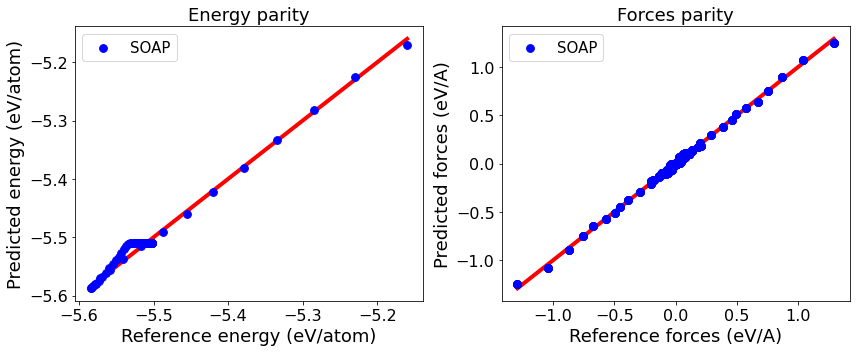

In [8]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
x = [test_energy_per_atom.min(), test_energy_per_atom.max()]
ax[0].set_title('Energy parity',fontsize=18)
ax[0].set_xlabel('Reference energy (eV/atom)',fontsize=18)
ax[0].set_ylabel('Predicted energy (eV/atom)',fontsize=18)
ax[0].tick_params(labelsize=16)
ax[0].plot(x, x, color="r",linewidth=4)
ax[0].scatter(test_energy_per_atom, pred_energy_srsr_per_atom,color='blue',label='SOAP',zorder=3,s=60)
ax[0].legend(markerscale=1,fontsize=15)

xx = [test_forces.flatten().min(), test_forces.flatten().max()]
ax[1].set_title('Forces parity',fontsize=18)
ax[1].set_xlabel('Reference forces (eV/A)',fontsize=18)
ax[1].set_ylabel('Predicted forces (eV/A)',fontsize=18)
ax[1].tick_params(labelsize=16)
ax[1].plot(xx, xx, color="r",linewidth=4)
ax[1].scatter(test_forces.flatten(), pred_forces_srsr.flatten(),color='blue',label='SOAP',zorder=3,s=60)
ax[1].legend(markerscale=1,fontsize=15)

plt.tight_layout()

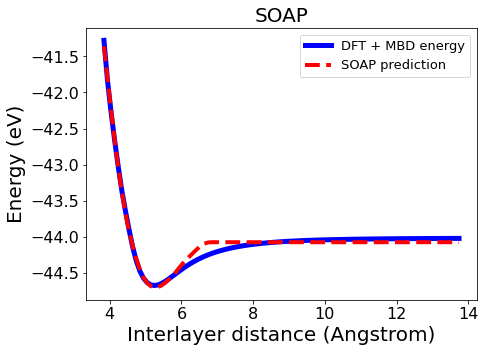

In [9]:
dist_list = []
error_forces = []

for i in np.arange(len(frames)):
    dist = frames[i].get_positions()[0,1]-frames[i].get_positions()[6,1]
    dist_list.append(dist)
    error = np.sqrt(np.sum(
        np.power( pred_forces_srsr[8*i:8*(i+1),1:3]-test_forces[8*i:8*(i+1),1:3],2)
    )/16)
    error_forces.append(error)

fig,ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('Interlayer distance (Angstrom)',fontsize=20)
ax.set_ylabel('Energy (eV)',fontsize=20)
ax.tick_params(labelsize=16)
ax.set_title('SOAP',fontsize=20)

ax.plot(dist_list, test_energy,'-',label='DFT + MBD energy',linewidth=5,color='blue')
ax.plot(dist_list, pred_energy_srsr,'--',label='SOAP prediction',linewidth=4,color='r')

ax.legend(markerscale=2,fontsize=13)